# POKEDEX

## INTEGRANTES:

Mariana Panszi

Erick Santillán 

Daniel Cabrera

Oscar Páez 

## PROBLEMA

Descripción: en el mundo Pokemón es necesario identificar frente a qué Pokemón te encuentras. Esto con el fin de poder tomar las mejores decisiones de cómo enfrentarlo o ayudarlo; sabiendo de qué tipo de Pokemón se trata, podemos tomar mejores decisiones basándonos en lo que ya se sabe de ese tipo de Pokemón. Creemos que para resolver este problema lo más óptimo es crear un "Pokedex" capaz de diferenciar entre tipos de Pokemón a través de una imágen.
Este problema es transferible a la vida real cuando exploradores o biólogos se enfrentan a la difícil tarea de identificar frente a qué animal se encuntran, y por lo tanto creemos que este problema puede trascender hacia la biología y por lo tanto nos parece útil presentar una solución. 

Objetivo: crear un "Pokedex" capaz de identificar el tipo de Pokemón con el que estamos tratando a partir de una imagen del Pokemón como entrada. 

Problemas de decisión: el Pokedex nos permite identificar frente a qué Pokemón estamos, y por lo tanto permite al usuario tomar una decisión más informada de cómo proceder frente a dicho Pokemón. Usar el Pokedex permite crear una mejor estrategia y una ventaja para el usuario. 

Imágenes en el siguiente link: [Pokemon](https://www.dropbox.com/sh/mod0kq6kdylbai4/AAB-f8ioHk8EHqtjnCEtnwZGa?dl=0)

Si vemos el problema desde la teoría de decisiones lo podemos identificar de la siguiente manera:

- Tomador de decisiones: Entrenador pokemon inexperto en los diferentes tipos de Pokemón que existen. Busca identificar por medio de una imagen a cualquier Pokemón.

- Espacio de opciones: la posibilidad de que la imagen que ingresa al Pokedex sea de alguno de los Pokemones identificados en nuestra base de imágenes. 

- Espacio de eventos: que sea o no sea el Pokemón que se quiere identificar. 

- Espacio de consecuencias: la acción que realice el entrenador pokemón una vez identificado el tipo de Pokemón al cual se enfrenta. 

1.- Cargar las librerías.

In [1]:
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import PIL
import random
from PIL import Image
from resizeimage import resizeimage
from scipy.misc import imread
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score

2.- Crear variables globales. En "mypath" están guardados los archivos y en "resized" se va a guardar una copia con el tamaño especificado en la variable "pixels".

In [2]:
mypath = "C:\\Users\\Erick Santillan\\Documents\\Python Scripts\\Pokemones\\n"
resized = "C:\\Users\\Erick Santillan\\Documents\\Python Scripts\\Pokemones\\Resized"
pixels = 100

## DATOS

Descripción: Se usó una base de datos con 180 imágenes. Para el modelo se usarán nueve tipos diferentes de Pokemón, y a cada tipo le corresponden 20 imágenes. Las imágenes son de distintos tamaños. Aunque es una base de datos relativamente pequeña, nos da la posibilidad de generar un modelo útil para estos nueve tipos de Pokemón y posteriormente se puede aumentar con más imágenes de cada tipo de Pokemón, o con más tipos de Pokemón.

Para poder trabajar de manera más efectiva con los datos, los nombres de los Pokemón se cambiaron por números. La correspondencia es como sigue:

- 0: Pikachu
- 1: Bulbasaur
- 2: Charmander
- 3: Jigglypuff
- 4: Squirtle
- 5: Cyndaquil
- 6: Psyduck
- 7: Togepi 
- 8: Eevee

Análisis exploratorio: análizamos las imágenes de manera individual, asegurándonos que cada carpeta contenedora sólo tuviera un tipo de pokemón, para no alimentar nuestro modelo con datos incorrectos. También nos aseguramos de que el modelo reconociera un Pokemón independientemente de su posición. 

Como se muestra unos pasos más adelante, voltéamos las imágenes para entrenar al modelo desde los distintos ángulos posibles de un Pokemón. Esto también duplica la muestra de imágenes que tenemos y nos da un mayor número de imágenes de entrenamiento. 

Para que las imágenes fueran comparables, fue necesario modificarles el tamaño, el cual puede ser modificado en la variable "pixels". Para el caso estándar se utilizan imágenes con un tamaño único de 100x100 pixeles. 
Al no ser un problema de texto o numérico, no fue necesario hacer imputaciones a los datos.

3.- El siguiente código guarda los arcvhivos en la carpeta resized.

In [3]:
raza_train = []
for j in range(9):
    mypath2 = mypath+str(j)
    onlyfiles = [f for f in listdir(mypath2) if isfile(join(mypath2, f))]
    n = len(onlyfiles)
    for i in range(n):
        raza_train.append(j)
        with open(mypath2+"\\"+onlyfiles[i], 'r+b') as f:
            with Image.open(f) as image:
                cover = resizeimage.resize_cover(image, [pixels, pixels])
                cover.save(resized+"\\"+"raza"+str(j)+"chango"+str(i)+".jpg", image.format)

4.- La siguiente instrucción guarda los nombres de los archivos de una carpeta en una lista.

In [4]:
onlyfiles = [f for f in listdir(resized) if isfile(join(resized, f))] 

5.- Leer las imágenes de la carpeta "resized" y cada pixel será una variable que tendrá el valor del color en su entrada. Están en formato "L", el cual es un formato en tonalidades amarillas.

In [5]:
features = []

for chango in onlyfiles:
    im = np.array(PIL.Image.open(resized+"\\"+chango).convert("L"))
    X = []
    for row in im:
        X = X + list(row)
    features.append(list(X))

6.- Se guarda la matriz "features" en un pandas DataFrame y se le añade la raza de cada pokemon.

In [6]:
column_names = ["P"+str(i) for i in range(int(pixels**2))]
changos_train = pd.DataFrame(features,columns=["P"+str(i) for i in range(int(pixels**2))])

changos_train['raza'] = raza_train

7.- Se voltean las imágenes para que el modelo se entrene con los pokemon viendo hacia ambos lados. Para que no se aprenda que "Charmander siempre tiene la cola a la derecha", esto se hará directo al DataFrame, sólo se van a "renombrar" las variables, esto es, el pixel 99 ahora va a ser el pixel 1.

In [7]:
renamed = {}
for i in range(int(pixels**2)):
    renamed['P'+str(i)] = 'P' + str((i//pixels)*pixels + pixels - i%pixels - 1)  

changos_train = changos_train.append(changos_train.rename(index=str, columns=renamed)[column_names + ['raza']]).reset_index().drop(columns='index')

8.- Verificar que en verdad se voltearon.

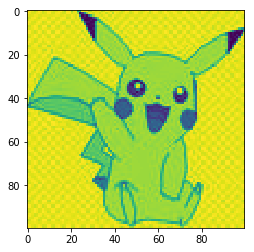

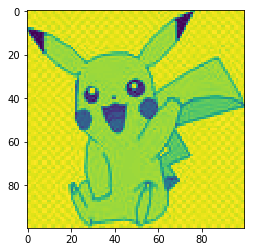

In [8]:
for row in changos_train[column_names].loc[[4,184]].values:
    plt.imshow(row.reshape(pixels, pixels))
    plt.show()

## MODELO 

Usamos dos modelos para ver cuál es mejor para nuestro Pokedex. El primer modelo fue supervisado con bosques aleatorios, usando cross validation para encontrar los mejores parámetros. Para medir la eficacia de este modelo se utilizó f1-score y una matriz de confusión. 

El segundo modelo se hizo no supervisado con PCA. Muestra una tabla con diferente número de componentes y arroja la varianza explicada y el f1-score de cada número de componentes. 

En ambos casos el muestreo es el mismo. Este se hizo a mano con 20% de los datos para probar el modelo, y 80% de los datos para entrenar el modelo. Esto se hizo así para asegurarse que hubiera la misma cantidad de cada tipo de Pokemón en cada conjunto. 

Creemos que estos modelos son los más apropiados por el número de datos con los que contamos. También hicimos un modelo supervisado y uno no supervisado para comparar los resultados y así poder elegir el mejor.  

9.- Se separa en entrenamiento y prueba, asegurándonos que las clases estén bien balanceadas. El muestreo se hace a mano.

In [9]:
changos_train['rand'] = [random.random() for i in range(changos_train.shape[0])] 
changos_train["rank"] = changos_train.groupby("raza")["rand"].rank("dense", ascending=False)

changos_test = changos_train.query("rank > 32").reset_index().drop(columns=['rand','index','rank'])
changos_train = changos_train.query("rank <= 32").reset_index().drop(columns=['rand','index','rank'])

10.- Entrenamos el modelo 1 con bosques aleatorios y cross validation con leave one out al ser tan poquitos datos.

In [10]:
grid_parametros = {'n_estimators': [175, 180, 185, 190],
                   'min_samples_split': [4,5,6,7]}
rf_cv = GridSearchCV(RandomForestClassifier(), grid_parametros,
                    verbose=10, n_jobs=-1, scoring='f1_micro', cv=32)

rf_cv.fit(changos_train.drop(columns=['raza']), changos_train.raza)
print("f1_score::::")
print(f1_score(changos_test.raza, rf_cv.predict(changos_test.drop(columns=['raza'])),average='micro'))

Fitting 32 folds for each of 16 candidates, totalling 512 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Paralle

f1_score::::
0.8194444444444444


In [61]:
rf_cv.best_params_

{'min_samples_split': 4, 'n_estimators': 190}

In [63]:
confusion_matrix(changos_test.raza, rf_cv.predict(changos_test.drop(columns=['raza'])))

array([[8, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 7, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 6, 0, 1, 0, 0, 0, 1],
       [1, 0, 0, 6, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 7, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 5, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 7, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 8, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 7]], dtype=int64)

11.- Entrenamos el modelo 2 con PCA.

In [11]:
from sklearn.decomposition import PCA

In [18]:
grid_parametros = {'n_estimators': [175, 180, 185, 190],
                   'min_samples_split': [4]}
componentes = []
varianza = []
f1 = []
for i in range(2,16):
    pca = PCA(n_components=i)
    pca.fit(changos_train.drop(columns='raza'))
    train_pca = pd.DataFrame(pca.transform(changos_train.drop(columns='raza')), columns=['P'+str(k) for k in range(i)])
    rf_cv = GridSearchCV(RandomForestClassifier(), grid_parametros, n_jobs=-1, scoring='f1_micro', cv=32)
    test_pca = pd.DataFrame(pca.transform(changos_test.drop(columns='raza')), columns=['P'+str(k) for k in range(i)])
    rf_cv.fit(changos_train.drop(columns=['raza']), changos_train.raza)
    f1.append(f1_score(changos_test.raza, rf_cv.predict(changos_test.drop(columns=['raza'])),average='micro'))
    componentes.append(i)
    varianza.append(sum(pca.explained_variance_ratio_))
pd.DataFrame({'Componentes': componentes, 'Var explicada': varianza, 'F1 score': f1})

,Componentes,Var explicada,F1 score
0,2,0.143676,0.791667
1,3,0.185991,0.763889
2,4,0.225769,0.763889
3,5,0.258734,0.791667
4,6,0.283524,0.805556
5,7,0.306226,0.763889
6,8,0.326134,0.791667
7,9,0.342207,0.750000
8,10,0.357142,0.763889
9,11,0.371576,0.763889


## DECISIÓN

Resultados: ambos modelos arrojan f1-scores relativamente altos, por lo que consideramos que ambos modelos son válidos para usar dentro del Pokedex. En este caso, el número de componentes óptimo será de 6. En ambos modelos, el f1-score oscila alrededor del 80%. Este score se podría mejorar aumentando la base de datos que tenemos de cada tipo de Pokemón. 
Lo que se puede observar por la matriz de confusión es que el pokemón tipo 6 es el que más propenso está a ser confundido con tros tipos de Pokemón. 

Conclusiones: Creemos que nuestro Pokedex es lo suficientemente exacto para que alguien en busca de convertirse en maestro pokemón lo use en sus aventuras diarias. Para mejorar el modelo sugerimos aumentar el número de pixeles en las imágenes (esto no nos fue posible porque algunas imágenes eran menores a 200 pixeles en su tamaño original) y aumentar el número de imágenes para entrenar el modelo. También creemos que con más imágenes el modelo 2 (PCA) puede funcionar mejor que el modelo 1. 
Finalmente creemos que se ha cumplido con el objetivo propuesto y que un tomador de decisiones se puede beneficiar con la información que estos modelos proporcionan. Las aplicaciones al mundo real de este tipo de modelos creemos que son bastante amplias, pero que tendrían especial utilidad en el campo de la biología, para identificar distintos tipos de animales y tener mejores herramientas para estudiarlos y ayudar a la conservación de distintas especies. 